# Compute Lya power spectrum from Eagle

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import Phys
# physical constants in cgs units
constants = Phys.ReadPhys()

from SpecWizard_Input import ReadData
from SpecWizard_BuildInput import Build_Input
from SpecWizard_ProjectData import SightLineProjection
import importlib
import SpecWizard_ComputeOpticaldepth

SpecWizard_ComputeOpticaldepth = importlib.reload(SpecWizard_ComputeOpticaldepth)

from SpecWizard_ComputeOpticaldepth import ComputeOpticaldepth

# pip3 install git+https://github.com/kyleaoman/pyread_eagle.git
import pyread_eagle as readeagle
import hydrangea

/cosma/local/Python/3.10.7/lib/python3.10/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/cosma/local/Python/3.10.7/lib/python3.10/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/cosma/local/Python/3.10.7/lib/python3.10/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


This class defines the B-spline kernel of Monaghan and Lattanzio, as used in Gadget-2


In [170]:
from IPython.core.display import display, HTML
toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
'''

toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(toggle_code_prepare_str + toggle_code_str))

def toggle_code():
    display(HTML(toggle_code_str))

toggle_code()

/tmp/ipykernel_78550/2422729417.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [171]:
from astropy.constants import astropyconst20 as constants
import copy
import astropy.units as units# Create a dictionary of physical constants from astropy. Each constant is stored in cgs (centimetre, gram, seconds)
import eagleSqlTools as sql
me     = "tt"
mine   = "vr983MZL"
conSQL = sql.connect(me, password=mine)

# Physical constants
c           = (constants.c.cgs / units.cm * units.s).value # speed of light
Grav        = (constants.G.cgs / units.cm**3 * units.s**2 * units.g).value  # Newton's constant [cm^3/s^2/g]
mH          = (constants.m_p.cgs / units.g).value                           # Proton mass [g]
me          = (constants.m_e.cgs / units.g).value                           # electron mass [g]
planck      = constants.h.cgs.value      # Planck's constant [erg s]
boltz       = constants.k_B.cgs.value    # Boltzmann constants [erg/K]
eps0        = 1./(4e0*np.pi)             # Permitivity of free space [-] 
e           = constants.e.esu.value      # electron charge [Fr]
sigma       = 6.63e-18                   # HI photo-ionisation cross section [cm^2]

# Astrophysical constants
GMsun       = (constants.GM_sun.cgs * units.s**2 / units.cm**3).value
Msun        = (constants.M_sun.cgs / units.g).value
pc          = (constants.pc.cgs / units.cm).value
kpc         = 1e3 * pc
Mpc         = 1e6 * pc
H100        = 100. * 1e5 / Mpc
micron      = 1e-4       # micron in cm
yr          = 3.15576e7  # year in seconds
sigmaT      = 1e4 * constants.sigma_T.value # Thomson cross-section in cm^2
# common conversion factors
eV          = constants.e.value * 1e7 # 1 electron volt in g (cm/s)^2
Ryd         = me * (e**2/(4.*np.pi*eps0))**2 * (4*np.pi)**2 / (8 * planck**2) # 1 Rydberg in g (cm/s)^2

phys = {'c':c, 'Grav':Grav, 'mH':mH, 'me':me, 'planck':planck, 'kB':boltz, 'sigma':sigma, 'eps0':eps0, 'e':e, 
        'GMsun':GMsun, 'Msun':Msun, 'pc':pc, 'kpc':kpc, 'Mpc':Mpc, 'micron':micron, 'yr':yr, 'H100':H100, 
        'eV':eV, 'Ryd':Ryd, 'sigmaT':sigmaT}

# case_B recombination coefficient
Tref = 1e4
def AlphaB(T=1e4):
    # case-B recombination rate
    lamb   = 315614 / T
    alphaB = 2.753e-14 * lamb**(1.5)*(1.0+(lamb/2.740)**(0.470))**(-2.2324)
    return alphaB
alphaB = AlphaB(Tref)

# Hydrogen constants
def SigmaCross(hnu_eV=13.6):
    # Verner et al ('96) fit to the photo-inization cross section
    # Input: energy of the photon in eV
    barn   = 1e-24
    sigma0 = 5.475e4 * 1e6 * barn
    E0     = 0.4298
    xa     = 32.88
    P      = 2.963
    #
    energy = np.array(hnu_eV)
    x      = energy/E0
    sigma  = sigma0 * (x-1)**2 * x**(0.5*P-5.5) * (1.+np.sqrt(x/xa))**(-P)
    if isinstance(sigma, (list, tuple, np.ndarray)):
        mask        = energy < 13.6
        sigma[mask] = 0
    else:
        if energy < 13.6:
            sigma = 0.0    
    return sigma
sigmaHI    = SigmaCross()  # HI photo-ionisation cross section at the threshold [cm^2]

# frequency-averaged photo-ionization cross sections
# 1) power-law spectrum with slope eta
eta        = 1.57 # from Haardt & Madau '12
nfactor    = eta/(eta+3)
sigmap     = nfactor * SigmaCross()  # frequency-averagd cross section [cm^2]
print("frequency-averaged cross section for power-law with slope eta={0:1.2f} is {1:1.3e}".format(eta, sigmap))

# 2) Blackbody spectrum
def BBspec(nu, T=1e5):
    # BB spectrum frequency nu for given temperature T
    return 2 * phys["planck"] * nu**3 / phys["c"]**2 / (np.exp(phys["planck"]*nu/(phys["kB"]*T))-1)
Ryd   = 13.6 * 1.60218e-12
nuIon = Ryd / phys["planck"]
nu    = nuIon * 10**(np.arange(-1, 10, 1e-4))
TBB   = 1e5
sBB   = BBspec(nu, T=TBB)
#
x       = nu/nuIon
mask    = x>= 1
num     = np.trapz(sBB[mask]/x[mask]**2, x[mask])
denom   = np.trapz(sBB[mask]/x[mask]**1, x[mask])
sigmaBB = num/denom * SigmaCross()
print("frequency-averaged cross section for BB with T={0:1.2e}K is {1:1.3e}".format(TBB, sigmaBB))


phys = {'c':c, 'Grav':Grav, 'mH':mH, 'me':me, 'planck':planck, 'kB':boltz, 'sigma':sigma, 'alphaB':alphaB, 'eps0':eps0, 'e':e, 
        'GMsun':GMsun, 'Msun':Msun, 'pc':pc, 'kpc':kpc, 'Mpc':Mpc, 'micron':micron, 'yr':yr, 'H100':H100, 
        'eV':eV, 'Ryd':Ryd, "sigmaHI":sigmaHI, "sigmaBB":sigmaBB, "sigmap":sigmap, "sigmaT":sigmaT}


# Set cosmology parameters
h         = 0.673
omegab    = 0.02230 / h**2
omegam    = (0.1188 + 0.0222) / h**2
Xh        = 1. - 0.2453
H0        = 100 * h * (1e5) / (1e6*phys["pc"])
rhoc      = 3*H0**2/(8*np.pi*phys["Grav"])   # [g/cm**3]

# store in dictionary
# mu is the "mean mass per particle"
cosmology = {'h':h, 'omegab':omegab, 'omegam':omegam, 'rhoc':rhoc, 'Xh':Xh, 'H0':H0,"mu":1.3}
cosmo     = copy.copy(cosmology)

# Correa+15 models for halo growth: M_h(z) = M_h(0) (1+z)^a exp(-bz)
Correa  = {'a':0.24, 'b':0.75}


def H(z):
    # Compute Hubble constant at this redshift
    Hz = cosmology["H0"] * np.sqrt(cosmology["omegam"] * (1.+z)**3 + (1.-cosmology["omegam"]))
    return Hz

toggle_code()

frequency-averaged cross section for power-law with slope eta=1.57 is 2.180e-18
frequency-averaged cross section for BB with T=1.00e+05K is 3.458e-18


/tmp/ipykernel_78550/1931091295.py:79: RuntimeWarning: overflow encountered in exp
  return 2 * phys["planck"] * nu**3 / phys["c"]**2 / (np.exp(phys["planck"]*nu/(phys["kB"]*T))-1)


## Spectra from snapshot

In [5]:
BuildInput = Build_Input()
BuildInput.FileType(sim_type='Eagle',snap_type='snapshot')
snapdir = '/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/snapshot_012_z003p017'
snapfile = 'snap_012_z003p017.0.hdf5'
BuildInput.SnapshotParams(path=snapdir,file=snapfile)
table_type     = 'specwizard_cloudy'
iondir         = '/cosma7/data/Eagle/SpecWizardCloudytables/HM12/'
fname          = '' 
SFR_properties = {'modify_particle':True,'ignore_particle':False,'Temperature [K]':1e4}
ElementIons    = [('Hydrogen','H I')]
BuildInput.SetIonTableParams(table_type=table_type,iondir=iondir,ions=ElementIons,fname=fname,SFR_properties=SFR_properties)

In [7]:
# Projection coordinates (fraction of the box)
x = 0.757
y = 0.805
z = 0.0

#
Wizard    = BuildInput.Sightline(ProjectionAxes=('simx','simy','simz'),ProjectionStart=(x,y,0))
snapshot  = ReadData(wizard = Wizard)
particles = snapshot.read_particles()

Warning! ProjectionLength NOT found. Setting default value : 1
Warning! SightLength NOT found. Setting default value : 1
Warning! ProjectionExtend NOT found. Setting default value : {'extend': False, 'extendfactor': 3}
Warning! nsight NOT found. Setting default value : 0


In [9]:
sightlineprojection  = SightLineProjection(Wizard)
projected_LOS        = sightlineprojection.ProjectData(particles)
vel_kms              = np.arange(projected_LOS["npix"] ) * projected_LOS['pixel_kms']['Value']
cspec                = ComputeOpticaldepth(Wizard)
opticaldepth         = cspec.MakeAllOpticaldepth(projected_LOS)


Sum column:  3.525286924939632e+18
Column from tau 3.5252869249396465e+18


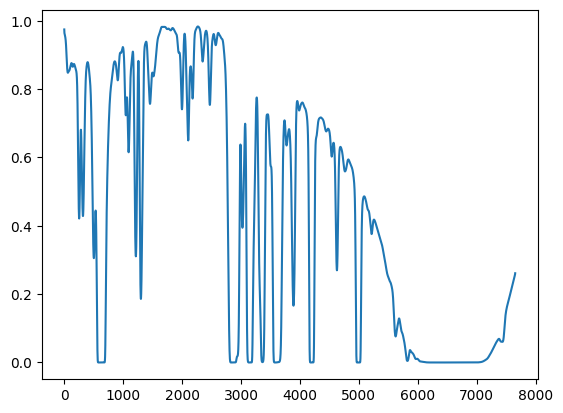

In [10]:
plt.plot(vel_kms, np.exp(-opticaldepth[('Hydrogen', 'H I')]['Optical depths']['Value']))

## Parallel version

In [17]:
# generate coordinates
seed        = 11
init        = np.random.seed(seed)
nsight      = 5
x           = np.random.uniform(size=nsight)
y           = np.random.uniform(size=nsight)
SightCoords = {'x':x, 'y':y}



In [14]:
import multiprocessing

In [44]:
def do_sight(isight, x, y, projections):
    Wizard = BuildInput.Sightline(ProjectionAxes=('simx','simy','simz'),ProjectionStart=(x,y,0))
    # read the particle data
    snapshot     = ReadData(wizard = Wizard)
    data         = snapshot.read_particles()
    
    # Project the particle data
    sightlineprojection  = SightLineProjection(Wizard)
    projected_LOS        = sightlineprojection.ProjectData(data)

    # Compute the spectrum
    cspec          = ComputeOpticaldepth(Wizard)
    opticaldepth   = cspec.MakeAllOpticaldepth(projected_LOS)
    
    # store the result
    result                = {"nsight": isight, "x":x, "y":y, 'OpticaldepthWeighted':opticaldepth, 'Projected':projected_LOS}
    projections[isight]   = result

In [45]:
ncpu   = 5      # number of cores to be used
#    
pool         = multiprocessing.Pool(ncpu)
manager      = multiprocessing.Manager()
projections  = manager.dict()

xs = SightCoords['x']
ys = SightCoords['y']
for i, (x,y) in enumerate(zip(xs, ys)):
    pool.apply_async(do_sight, args=(i, x, y, projections))
pool.close()
pool.join()

Warning! ProjectionLength NOT found. Setting default value : 1
Warning! ProjectionLength NOT found. Setting default value : 1Warning! ProjectionLength NOT found. Setting default value : 1Warning! SightLength NOT found. Setting default value : 1Warning! ProjectionLength NOT found. Setting default value : 1Warning! ProjectionLength NOT found. Setting default value : 1




Warning! SightLength NOT found. Setting default value : 1Warning! SightLength NOT found. Setting default value : 1Warning! ProjectionExtend NOT found. Setting default value : {'extend': False, 'extendfactor': 3}Warning! SightLength NOT found. Setting default value : 1Warning! SightLength NOT found. Setting default value : 1




Warning! ProjectionExtend NOT found. Setting default value : {'extend': False, 'extendfactor': 3}Warning! nsight NOT found. Setting default value : 0Warning! ProjectionExtend NOT found. Setting default value : {'extend': False, 'extendfactor': 3}Warning! ProjectionExtend NOT found. Setting defaul

In [157]:
print(projections[0]['Projected']['Header']['BoxSize'].keys())
hf.close()

dict_keys(['Value', 'Info'])


In [164]:
# save as hdf5 file
import h5py

hf.close()
#
hf = h5py.File('data.h5', 'w')
hf.attrs['nsight'] = nsight

def h5_WriteVariable(name, variable, group):
    # write variable and its attributes to a given group
    try:
        group[name] = variable['Value']
        for info in variable['Info'].keys():
            group[name].attrs[info] = variable['Info'][info]
    except:
        group[name] = variable
def h5_WriteGroup(name, variable, group):
    for key in variable.keys():
        try:
            h5_WriteVariable(key, variable[key], group)
        except:
            egroup = hf.create_group(key)
            h5_WriteGroup(key, variable[key], egroup)
    
for i in np.arange(nsight):
    projection = projections[i]
    #
    if i == 0:
        Headers = ['Header']
        for header in Headers:
            group = hf.create_group(header)
            h5_WriteGroup(header, projection['Projected'][header], group)
        h5_WriteVariable('pixel', projection['Projected']['pixel'], group)
        h5_WriteVariable('pixel_kms', projection['Projected']['pixel_kms'], group)
        h5_WriteVariable('npix', projection['Projected']['npix'], group)        
    
    # 
    gname = 'SightLine{0:1d}'.format(i)
    group = hf.create_group(gname)
    #
    group.attrs['x'] = projection['x']
    group.attrs['y'] = projection['y']
    #
    group  = hf.create_group(gname+'/OpticaldepthWeighted')
    for element in projection['OpticaldepthWeighted'].keys():
        name = gname + '/OpticaldepthWeighted' + '/' + element[0] + '_' + element[1]
        egroup = hf.create_group(name)
        for variable in projection['OpticaldepthWeighted'][element].keys():
            h5_WriteVariable(variable, projection['OpticaldepthWeighted'][element][variable], egroup)


    Entries = ['Element-weighted', 'Ion-weighted']
    for entry in Entries:
        for element in projection['Projected'][entry].keys():
            name = gname + '/Projected' + '/' + entry + '/' + element
            egroup = hf.create_group(name)
            for variable  in projection['Projected'][entry][element].keys():
                h5_WriteVariable(variable, projection['Projected'][entry][element][variable], egroup)
    #
    name = gname + '/Projected' + '/Mass-weighted'
    egroup = hf.create_group(name)
    for variable in projection['Projected']['Mass-weighted']:
        h5_WriteVariable(variable, projection['Projected']['Mass-weighted'][variable], egroup)
         




hf.close()

0.1802696888767692 0.4854270981677824 0.1802696888767692 0.4854270981677824
0.019475241487624584 0.012780814590608647 0.019475241487624584 0.012780814590608647
0.4632185264983446 0.4873716073198716 0.4632185264983446 0.4873716073198716
0.7249339291921478 0.9418066523433661 0.7249339291921478 0.9418066523433661
0.42020360458772743 0.8507950893767787 0.42020360458772743 0.8507950893767787


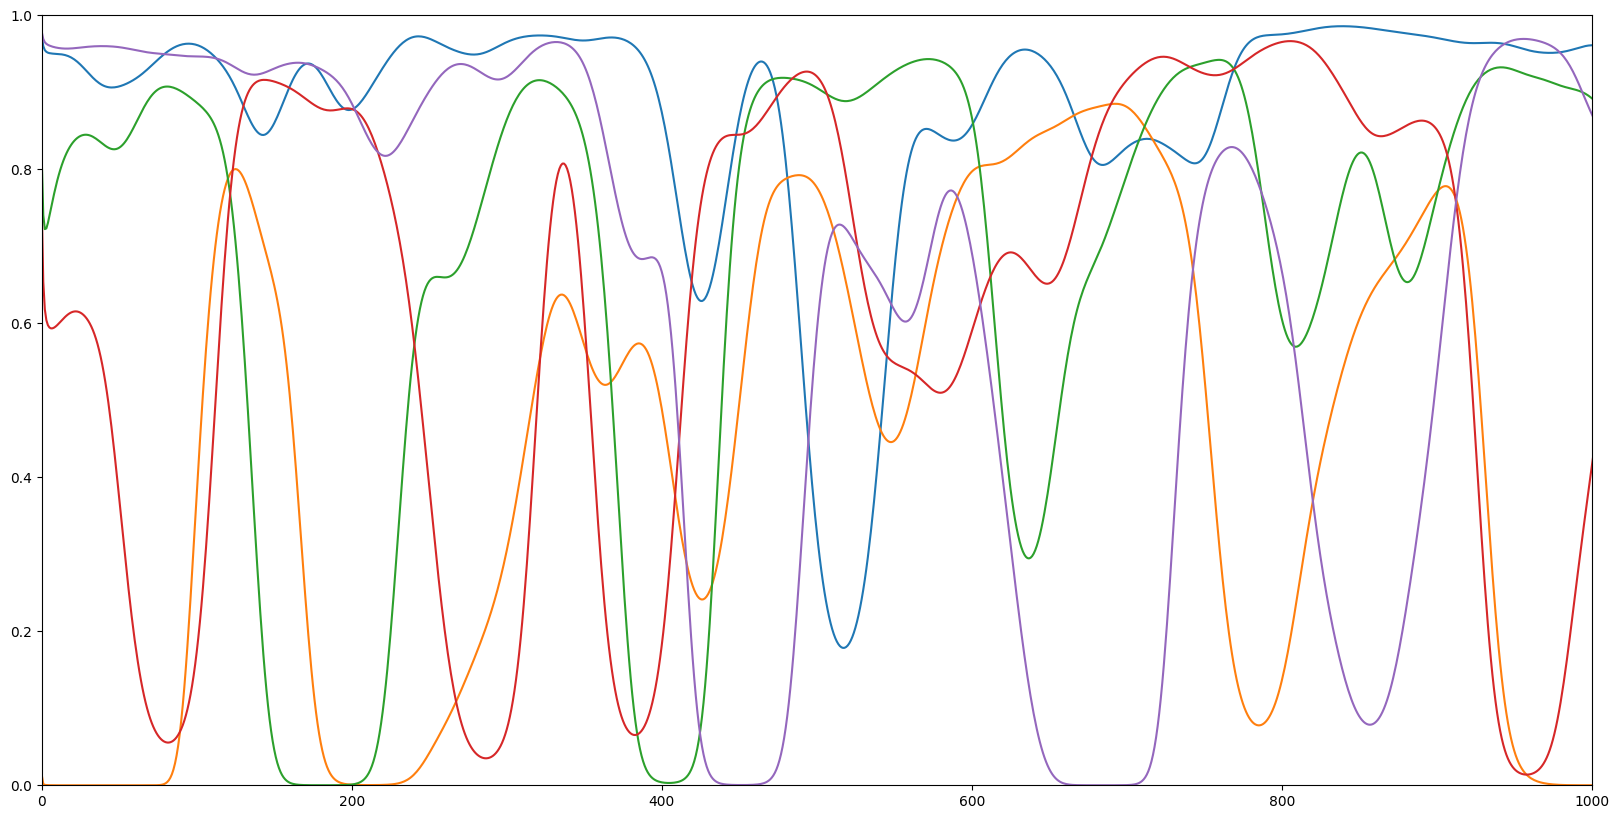

In [47]:
# make some plots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

for i in np.arange(nsight):
    tau = projections[i]['OpticaldepthWeighted'][('Hydrogen', 'H I')]['Optical depths']['Value']
    x   = projections[i]['x']
    y   = projections[i]['y']
    print(x, y, SightCoords['x'][i], SightCoords['y'][i])
    ax.plot(vel_kms, np.exp(-tau))
    


ax.set_xlim(0, 1000)
ax.set_ylim(0, 1)

fig.show()

## Spectra from the data base

In [229]:
# sql query parameters
simname   = {'sql':'RefL0100N1504','particles':'L0100N1504/PE/REFERENCE/'}
sightline = {'x':22, 'y':22, 'radius':5.0}
sqlpars   = {'box':100., 'm_min':2e9, 'm_max':1e12, 'fraction':1, 'x':sightline['x'], 'y':sightline['y'], 'radius':sightline['radius']}   # select halos with given mass
variables = [{'type':1, 'name':'Coordinates'}]
snapnum   = 12
class Eagle:
    def __init__(self, simname=simname, sqlpars=sqlpars,snapnum=snapnum):
        ''' Methods to interface SQL database and particles from snapshots '''
        self.snapnum    = snapnum
        self.simname    = simname   # particlular simulation

        # read header of snapshot data
        self.eaglebase  = '/cosma7/data/Eagle/ScienceRuns/Planck1/'
        self.subbase    = 'snapshot_'
        self.partbase   = 'snap_'
        # create file name
        file            = self.eaglebase + self.simname['particles'] + '/data/' + self.subbase 
        file           += self.snapbase(snapnum) + '/' + self.partbase + self.snapbase(snapnum) + '.0.hdf5'
        self.fname      = file
        self.header = self.ReadGroup()
        
        
    def QueryDB(self, sqlpars):
        ''' Query data base '''
        mhistory = '''SELECT 
                          FOF.Group_M_Crit200 as m200,
                          FOF.Group_R_Crit200 as r200, 
                          FOF.GroupCentreOfPotential_x as x, 
                          FOF.GroupCentreOfPotential_y as y, 
                          FOF.GroupCentreOfPotential_z as z,
                          FOF.Redshift as redshift
                  FROM 
                          {simname}_FOF as FOF 
                  WHERE 
                          FOF.Group_M_Crit200 between {m_min:1.2e} and {m_max:1.2e}
                          and FOF.RandomNumber < {fraction:1.3f} 
                          and FOF.SnapNum = {snapnum:3d}
                          and 
                          iif(abs(FOF.GroupCentreOfPotential_x - {xsight}) < 0.5*{boxsize}, abs(FOF.GroupCentreOfPotential_x - {xsight}), {boxsize}-abs(FOF.GroupCentreOfPotential_x - {xsight})) < {radius}
                          and
                          iif(abs(FOF.GroupCentreOfPotential_y - {ysight}) < 0.5*{boxsize}, abs(FOF.GroupCentreOfPotential_y - {ysight}), {boxsize}-abs(FOF.GroupCentreOfPotential_y - {ysight})) < {radius}
                  ORDER BY 
                          FOF.Group_M_Crit200 desc'''.format(
                                                    simname=self.simname['sql']
                                                    , m_min=sqlpars['m_min']
                                                    , m_max=sqlpars['m_max']
                                                    , boxsize=sqlpars['box']
                                                    , xsight = sqlpars['x']
                                                    , ysight = sqlpars['y']
                                                    , radius = sqlpars['radius']
                                                    , fraction = sqlpars['fraction']
                                                    , snapnum=self.snapnum)
        return sql.execute_query(conSQL, mhistory)
    
    def SetUnit(self, vardescription = 'text describing variable', Lunit=phys['Mpc'], aFact=1.0, hFact=1.0):
        ''' Set units of a variable '''
        return {'VarDescription': vardescription, 'CGSConversionFactor':Lunit, 'aexp-scale-exponent' :aFact, 'h-scale-exponent': hFact}
        
    
    def ReadGroup(self, groupname ='Header'):
        # read all entries for this particular hdf5 group
        hfile = h5py.File(self.fname, "r")
        group    = hfile[groupname]
        grp_dict = {}
        for k in group.attrs.keys():
            grp_dict[k]= group.attrs[k]
        
        hfile.close()
    
        return dict(grp_dict)
    def ToCGS(self, variable,comoving=False):
        ''' Apply cosmological scaling to retrun a variable in cgs units '''
        value  = variable['Values']
        aparam = 1./(1.+self.snapheader['Cosmo']['Redshift'])
        hparam = self.snapheader['Cosmo']['HubbleParam']
        ascale = aparam**variable['Info']['aexp-scale-exponent']
        if comoving:
            ascale = 1
        hscale = hparam**variable['Info']['h-scale-exponent']
        tocgs  = variable['Info']['CGSConversionFactor']
        return variable['Values']*hscale*ascale*tocgs    
    def ReadHeader(self):
        ''' Read cosmological parameters'''
        #
        # read header information and store in default format
        header = self.ReadGroup()

        # the unit and h-dependence of Eagle is not stated; We assume it is in cMpc/h
        boxsize  = np.array([1., 1.0, 1.0 ]) * header['BoxSize']
        boxunit  = self.SetUnit(vardescription="Extent of simulation volume", 
                                Lunit=phys['Mpc'], 
                                aFact=1.0, 
                                hFact=-1.0)
        box      = {'Value':boxsize, 'Info':boxunit}
        h        = header['HubbleParam']
        #
        cosmo    = {'Redshift'    : header['Redshift'], 
                    'HubbleParam' : h,
                    'OmegaMatter' : header['Omega0'],
                    'OmegaBaryon' : header['OmegaBaryon'],
                    'OmegaLambda' : header['OmegaLambda']}

        numpartval   = header['NumPart_Total'][0]
        numpartunit  = self.SetUnit(vardescription="Total number of gas particles in the simulation", 
                                Lunit=1, 
                                aFact=0, 
                                hFact=0)
        numpart      = {'Value':numpartval,'Info':numpartunit}

        # compute some extra variables
        H0            = h * 100 * 1e5 / phys["Mpc"]      # H0 in 1/s
        rhoc          = 3*H0**2 / (8*np.pi*phys["Grav"]) # critical density in g/cm^3
        cosmo["H0"]   = H0
        cosmo["rhoc"] = rhoc
        cosmo["rhob"] = rhoc * cosmo["OmegaBaryon"]
            
        Header = {'BoxSize':box, 'Cosmo' : cosmo, 'NumPartTot':numpart}
        
        return Header
    
    def snapbase(self, snapnum=28):
        ''' return file base for particle file '''
        bases      = ['000_z020p000', '001_z015p132', '002_z009p993'
                  , '003_z008p988', '004_z008p075', '005_z007p050'
                  , '006_z005p971', '007_z005p487', '008_z005p037'
                  , '009_z004p485', '010_z003p984', '011_z003p528'
                  , '012_z003p017', '013_z002p478', '014_z002p237'
                  , '015_z002p012', '016_z001p737', '017_z001p487'
                  , '018_z001p259', '019_z001p004', '020_z000p865'
                  , '021_z000p736', '022_z000p615', '023_z000p503'
                  , '024_z000p366', '025_z000p271', '026_z000p183'
                  , '027_z000p101', '028_z000p000']
        try:
            return bases[snapnum]
        except:
            print('This snapshot does not exists, sorry')
            
    def periodic(self, x, box):
        mask = x < 0
        x[mask] += box
        mask = x > box
        x[mask] -= box
        return x
    
    def distance(self, x, box):
        mask = x < -box/2
        x[mask] += box
        mask = x > box/2
        x[mask] -= box
        return x
    
    def NHI(self, Mh=1e10, Rh=10, b=10.0, Gamma=1e-12, z=3.0):
        '''Column density as a function of impact parameter '''
        Nhref = 10**(15.5) * ((1+z)/4)**5 * (Mh/1e10)**(1./3.) * (Gamma/1e-12)**(-1.)
        return Nhref * (Rh/b)**3
    def TauProf(self, LogNHI=13.0, b=20.0, v=np.array([0.0])):
        ''' Gaussian optical depth profile '''
        f_value  = 0.4164
        lambda0  = 1215.67*1e-8
        sigma    = phys["c"] * np.sqrt(3*np.pi*phys["sigmaT"]/8.) * f_value * lambda0
        tau0     = sigma * 10**LogNHI / np.sqrt(np.pi*b**2) / 1e5
        return tau0 * np.exp(-v**2/b**2)

    def Hubble(self, z):
        return cosmology['H0'] * np.sqrt(cosmology['omegam']*(1+z)**3+(1-cosmology['omegam']))

    def FluxPS(self, flux, meanf=1.0, box=1e3):
            ''' Function that calculates the flux power spectrum
                Input: Flux (exp(-tau))
                       MeanFlux: average flux of all your spectra NOT of the individual spectra, or theoretical Flux eg from oñorbe fit
                       N: Number of pixels
                       V: velocity of the box
                output: Kvals in
                      : K*PS

            '''
            N        = len(flux)
            V        = box

            dv       = V / N
            freqs    = np.fft.fftfreq(N) 
            freqs   *= (2 * np.pi / dv)
            indx     = np.argsort(freqs)
            indx     = indx[freqs[indx] >= 0]
            freqs    = freqs[indx]

            delta    = (flux - meanf) / meanf 
            fourier  = np.fft.fft(delta)[indx]
            fourier  /= N
            pwr_spec = np.abs(fourier)**2
            pwr_spec *= V


            kPk      = pwr_spec * freqs 

            return freqs, kPk

eagle = Eagle()

Lowest/highest z value in the HM table = 1.05 6.75


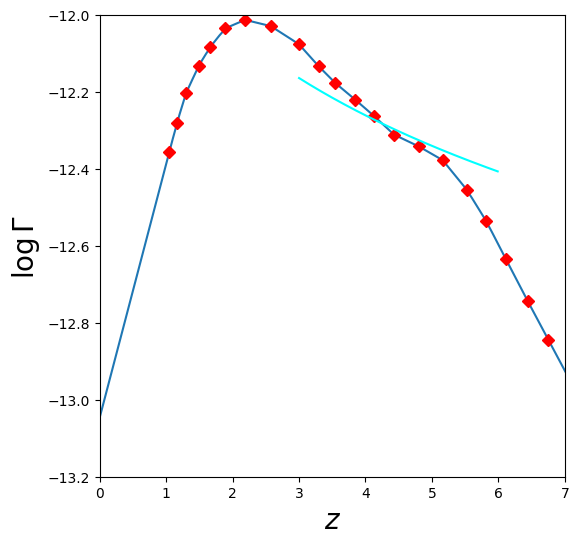

In [203]:
# Read Haardt & Madau 2012 photoionization rate
from scipy import interpolate
filename  = "/cosma/home/dphlss/tt/Data/HaardtMadau2012.dat"
data      = np.loadtxt(filename, delimiter=",", comments='#', ).T
zHM       = data[0]
GammaHM   = data[1] * 1e-12
HM12      = {'z':zHM, 'Gamma':GammaHM}
print("Lowest/highest z value in the HM table = {0:1.2f} {1:1.2f}".format(zHM.min(), zHM.max()))
# Create interpolation function
interpHM    = interpolate.interp1d(zHM, np.log10(GammaHM), fill_value="extrapolate", bounds_error=False)   
def LogGammaHM(z):
    value = interpHM(z)
    if(len(z) == 1):
        return value[0]
    else:
        return value

fontsize=20
fig, ax = plt.subplots(1,  1, figsize = (6, 6))
zs = np.arange(0, 8, 0.1)
ax.plot(zs, LogGammaHM(zs))
ax.set_xlabel(r"$z$", fontsize=fontsize)
ax.set_ylabel(r"$\log\Gamma$",fontsize=fontsize)
ax.plot(zHM, np.log10(GammaHM), 'D', color='red')
# test scaling (1+z)
zref  = 4.25
zplot = np.arange(3, 6, 0.01)
gplot = 10**LogGammaHM([zref]) * (1+zref) / (1.+zplot)
ax.plot(zplot, np.log10(gplot), color='cyan')

ax.set_xlim(0, 7)
ax.set_ylim(-13.2, -12)

fig.show()
toggle_code()

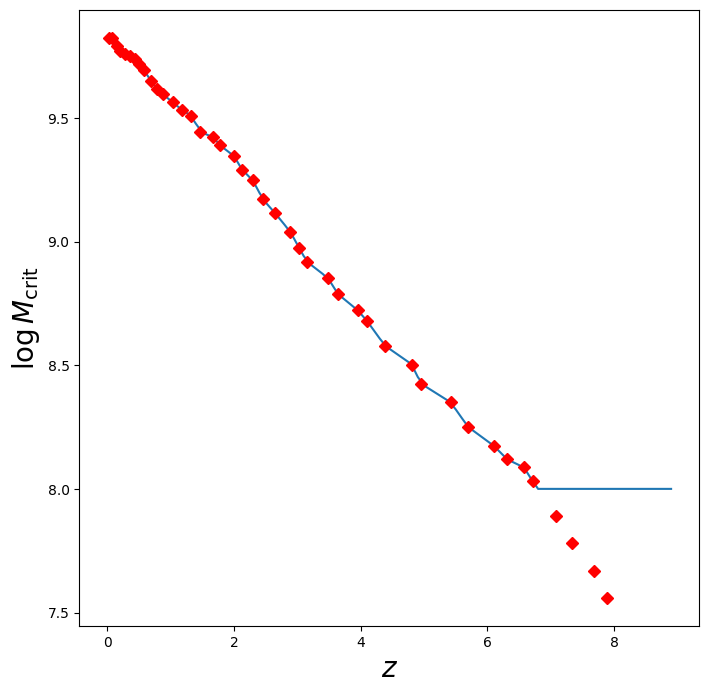

In [204]:
filename  = "/cosma/home/dphlss/tt/Data/Mcrit-Okamoto08.dat"
data      = np.loadtxt(filename, delimiter=",", comments='#', ).T
zplus1    = data[0]
Mcrit     = data[1]
Okamoto   = {'z':zplus1-1, 'LogMcrit':Mcrit}    
minmax    = [Mcrit[0], Mcrit[-1]]

# Create interpolation function
interpMcrit = interpolate.interp1d(Okamoto["z"], Okamoto["LogMcrit"], fill_value='extrapolate', bounds_error=False)
def LogMcritOkamoto(z):
    value = interpMcrit(z)
    if(len(z) == 1):
        value = value[0]
        if z <= min(Okamoto['z']):
            value = Okamoto['LogMcrit'][0]
        if z >= max(Okamoto['z']):
            value = Okamoto['LogMcrit'][-1]
        return np.max([8.0, value])
    else:
        mask = z <= min(Okamoto['z'])
        value[mask] = Okamoto['LogMcrit'][0]
        mask = z >= max(Okamoto['z'])
        value[mask] = Okamoto['LogMcrit'][-1]
        mask        = value < 8
        value[mask] = 8
        return value
    
def LogMcritOkamoto(z):
    value = interpMcrit(z)
    try:
        mask = z <= min(Okamoto['z'])
        value[mask] = Okamoto['LogMcrit'][0]
        mask = z >= max(Okamoto['z'])
        value[mask] = Okamoto['LogMcrit'][-1]
        mask        = value < 8
        value[mask] = 8
        return value
    except:
        value = value[0]
        if z <= min(Okamoto['z']):
            value = Okamoto['LogMcrit'][0]
        if z >= max(Okamoto['z']):
            value = Okamoto['LogMcrit'][-1]
        return np.max([8.0, value])
        
fig, ax   = plt.subplots(1,  1, figsize = (8, 8))
zs = np.arange(0, 9, 0.1)
ax.plot(zs, LogMcritOkamoto(zs))
ax.plot(zplus1-1, Mcrit, 'D', color='red')
ax.set_xlabel(r"$z$", fontsize=fontsize)
ax.set_ylabel(r"$\log M_{\rm crit}$", fontsize=fontsize)
fig.show()
toggle_code()

In [286]:
class Absorber:
    def __init__(self, z=3.0, Gamma0=1e-12, LogMcrit=8.99, Tgas=1.5e4, fgas=0.6, cosmology=cosmology, phys=phys):
        self.z        = z
        self.Gamma0   = Gamma0
        self.LogMcrit = LogMcrit
        self.fgas     = 0.6
        self.Tgas     = Tgas
        #
        self.cosmology = cosmology
        self.phys      = phys
        #
        
    def Hubble(self):
        return self.cosmology["H0"] * np.sqrt(cosmology["omegam"]*(1+self.z)**3+1.-self.cosmology['omegam'])

    def Rvir(self, LogMh=12):
        ''' Virial radius of halo of given mass
        input:
        LogMh  : log 10 of halo mass in solar masses
        Rh     : virial radius in proper kpc
        '''
        Rh = (self.phys["Grav"] * 10**LogMh * self.phys["Msun"] / (10*self.Hubble())**2)**(1./3.)
        return Rh/self.phys["kpc"]
    
        
    def NHI(self, LogMh=12.0, b=1.0):
        ''' Column density for sightline passign with impact paramegter b near halo of mass Mh 
        input:
        LogMh  : log 10 of halo mass in solar masses
        b      : impact parameter in proper kpc '''
        Nhref  = 10**(15.5) * ((1+self.z)/4)**5 * (10**LogMh/1e10)**(1./3.)
        Nhref *= (self.fgas/0.6)**2 * (self.Gamma0/1e-12)**(-1.)
        Nhref *= self.AlphaB(T=self.Tgas)/self.AlphaB(T=1.5e4)
        #
        Rh     = self.Rvir(LogMh=LogMh)
        print(LogMh[0:10])
        print(Rh[0:10])
        print(b[0:10])
        return Nhref * (b/Rh)**(-3.0)
    
    def AlphaB(self, T=1e4):
        # case-B recombination rate
        lamb   = 315614 / T
        alphaB = 2.753e-14 * lamb**(1.5)*(1.0+(lamb/2.740)**(0.470))**(-2.2324)
        return alphaB
    
z = 3.0
Gamma = 10**LogGammaHM([z])
LogMcrit = LogMcritOkamoto(z)

absorber = Absorber(z=z, Gamma0=Gamma, LogMcrit=LogMcrit)

In [264]:
absorber = Absorber(z=z, Gamma0=Gamma, LogMcrit=LogMcrit)
absorber.NHI(LogMh=12.0, b=10.0)

8.073869520868325e+18

In [291]:
if False:
    xs = SightCoords["x"]
    ys = SightCoords["y"]
    Halos = {}
    for i, (x,y) in enumerate(zip(xs, ys)):
        Halos[i] = {}
        sightline = {'x':x*sqlpars['box'], 'y':y*sqlpars['box'], 'radius':5.0}
        sqlpars   = {'box':100., 'm_min':2e9, 'm_max':1e14, 'fraction':1, 'x':sightline['x'], 'y':sightline['y'], 'radius':sightline['radius']}   # select halos with given mass
        halos     = eagle.QueryDB(sqlpars)
        Halos[i]['x'] = x
        Halos[i]['y'] = y
        Halos[i]['halos'] = halos
    boxsize = 100.       

In [292]:
print(Halos[0])

{'x': 0.1802696888767692, 'y': 0.4854270981677824, 'halos': array([(8.8408831e+11, 73.81358 , 13.610316 , 45.50587 , 46.223137, 3.0165045),
       (4.7231199e+11, 59.891754, 22.205986 , 48.506363, 96.89691 , 3.0165045),
       (4.3132079e+11, 58.108097, 22.669016 , 43.803978, 42.38676 , 3.0165045),
       ...,
       (2.0016449e+09,  9.692238, 19.800966 , 44.535316, 96.716385, 3.0165045),
       (2.0007087e+09,  9.690788, 14.7003355, 49.534515,  9.864761, 3.0165045),
       (2.0002102e+09,  9.690102, 19.69131  , 45.21649 , 54.540756, 3.0165045)],
      dtype=[('m200', '<f4'), ('r200', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('redshift', '<f4')])}


In [289]:
Lines = {}
for i, (x,y) in enumerate(zip(xs, ys)):
    if i==0:
        halo     = Halos[i]
        Lines[i] = {}
        #
        xsight   = halo['x'] * boxsize
        ysight   = halo['y'] * boxsize
        #
        xh       = halo['halos']['x']
        yh       = halo['halos']['y']
        zh       = halo['halos']['z']
        Mh       = halo['halos']['m200']
        #
        dx       = xsight - xh
        dx       = eagle.distance(dx, boxsize)
        dy       = ysight - yh
        dy       = eagle.distance(dy, boxsize)
        b        = np.sqrt(dx**2+dy**2)
        # convert from co-moving Mpc to proper kpc
        bkpc     = b*1e3 / (1+absorber.z)
        nhi      = absorber.NHI(LogMh=np.log10(Mh), b=bkpc)
        Lines[i]['b'] = b
        Lines[i]['dx'] = dx
        Lines[i]['dy'] = dy
        Lines[i]['b']  = b
        Lines[i]['bkpc'] = bkpc
        Lines[i]['LogNHI'] = nhi
        Lines[i]['LogMh']  = np.log10(Mh)
    
    

[11.946496  11.67423   11.634801  11.634542  11.418559  11.394429
 11.360165  11.3374195 11.1854515 11.036595 ]
[inf inf inf inf inf inf inf inf inf inf]
[1339.9907 1044.7941 1658.3912 1285.834  1048.76   1199.0985 1503.5736
 1100.4979 1078.6986  525.4284]


/tmp/ipykernel_78550/3527812636.py:22: RuntimeWarning: overflow encountered in true_divide
  Rh = (self.phys["Grav"] * 10**LogMh * self.phys["Msun"] / (10*self.Hubble())**2)**(1./3.)
/tmp/ipykernel_78550/3527812636.py:39: RuntimeWarning: divide by zero encountered in power
  return Nhref * (b/Rh)**(-3.0)


In [285]:
print(Lines[0]['bkpc'][0:10])

[1339.9907 1044.7941 1658.3912 1285.834  1048.76   1199.0985 1503.5736
 1100.4979 1078.6986  525.4284]


0.1802696888767692 [13.610316 22.205986 22.669016 19.886927 17.112665 22.815    22.602247
 13.821268 17.024267 19.675005]


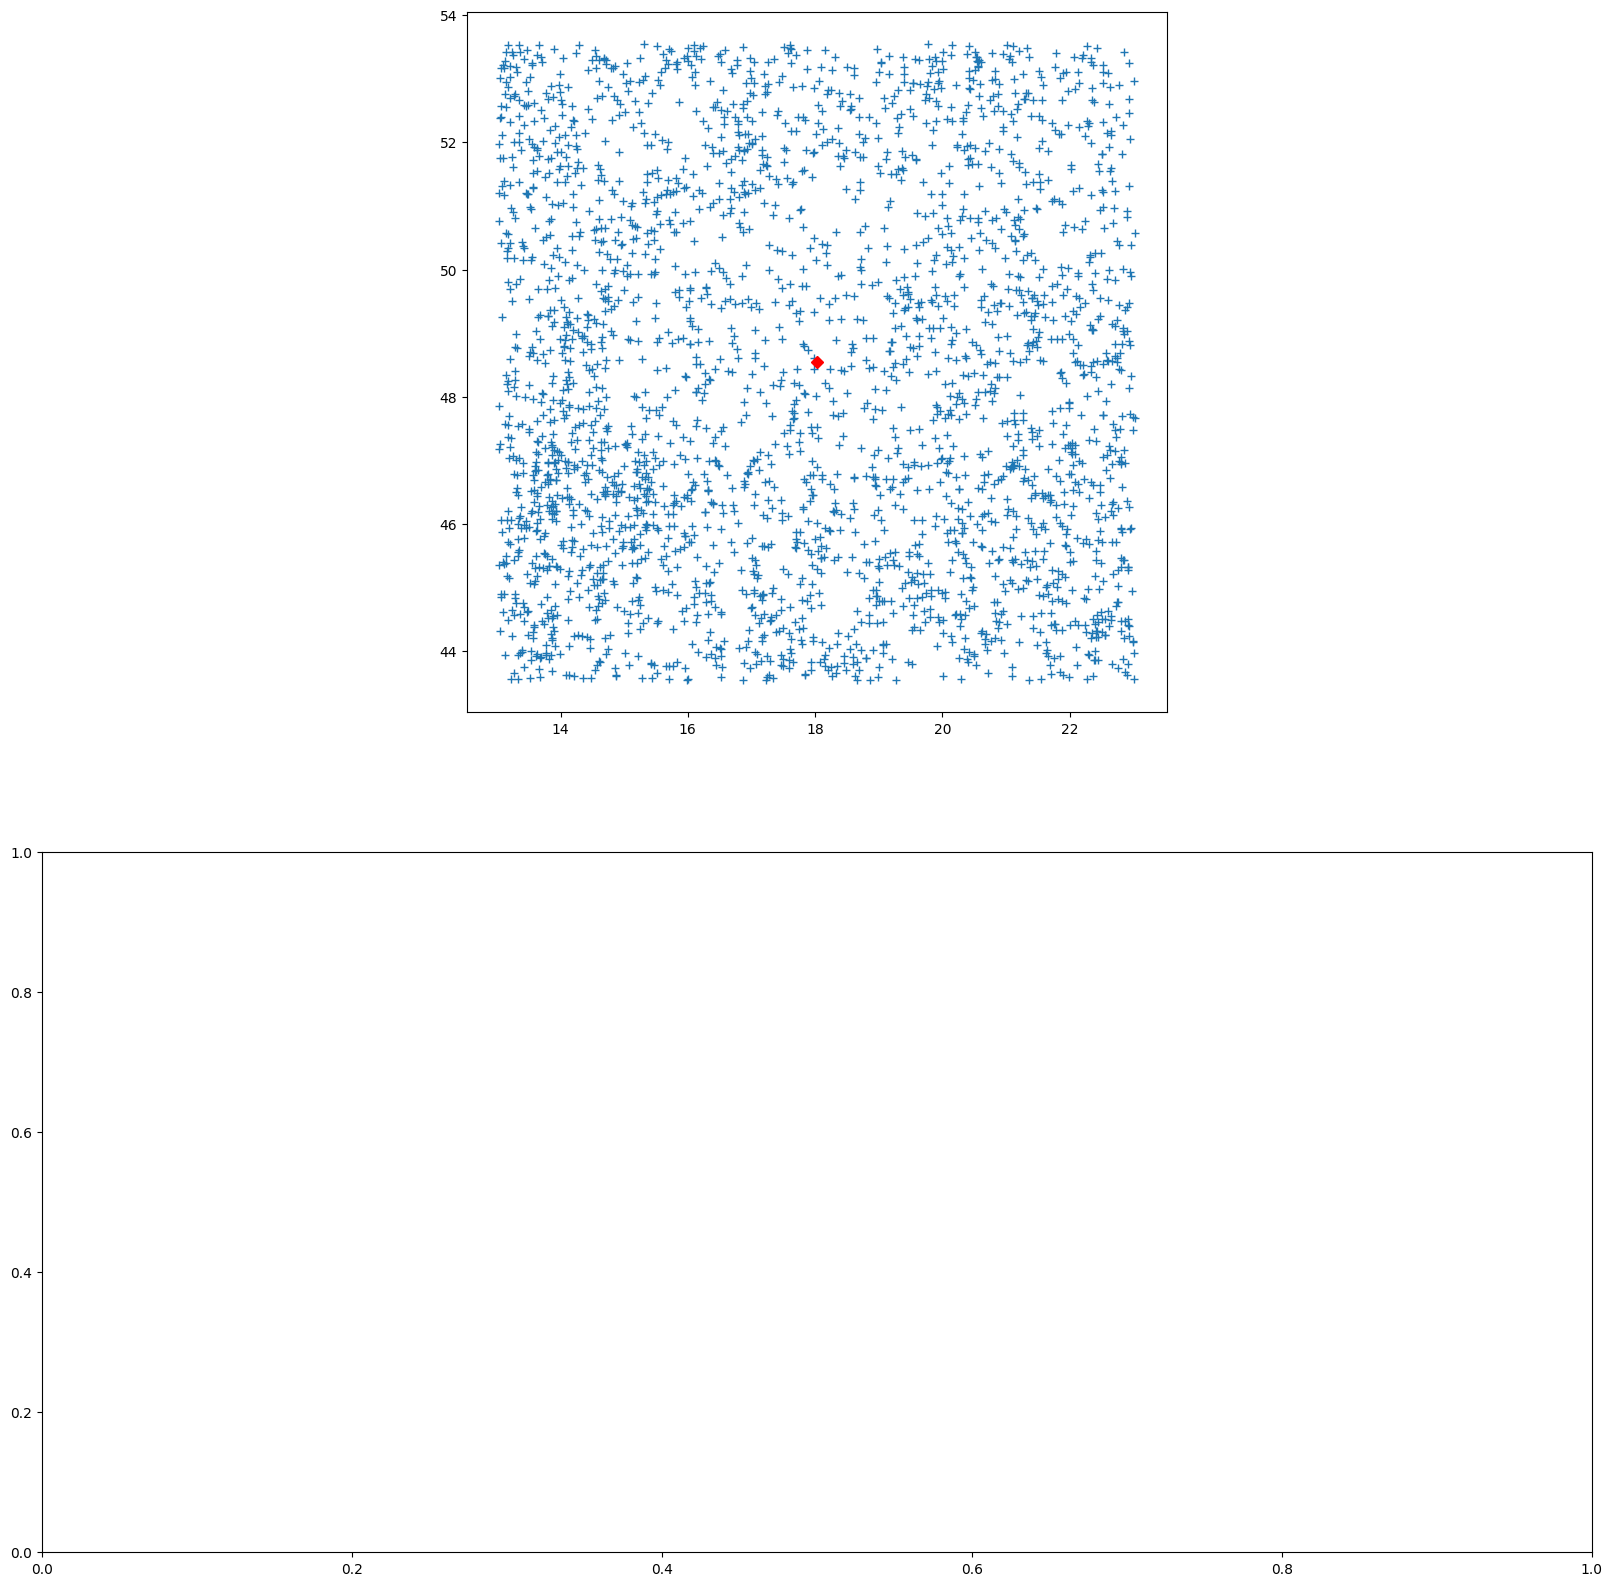

In [208]:
fig, ax = plt.subplots(2, 1, figsize = (20, 20))

ax[0].plot(eagle.periodic(halos['x'], boxsize), eagle.periodic(halos['y'], boxsize), '+')
ax[0].set_aspect('equal')

ax[0].plot(xs[0]*boxsize, ys[0]*boxsize, 'D', color='red')



fig.show()

print(xs[0], halos['x'][0:10])